## Single small istance

In [1]:
import numpy as np
import cvxpy as cp

# Creates a NumPy vector of size C with all zeros except for a 1 at the given index
def get_unit_vector(index, C):
    x = np.zeros(C)
    x[index] = 1.0
    return x

# Initializes x1 (x2) as a vector with all zeros except for a 1 at the position 
# corresponding to the index of the largest (smallest) value of v for which w >= v[b] (w < v[b]).
def initialize_B(v, w, C):
    # List of indices b that satisfy w >= v[b]
    b1_candidates = [b for b in range(C) if w >= v[b]]
    # List of indices b that satisfy w < v[b]
    b2_candidates = [b for b in range(C) if w < v[b]]

    # Case where w is smaller than the minimum of v.
    # Take the minimum of v.
    if not b1_candidates: 
        b1 = np.argmin(v)
    # Otherwise, take the index of the largest value of v for which w >= v[b]
    else:
        b1 = b1_candidates[-1]

    # Case where w is larger than the maximum of v.
    # Take the maximum of v.
    if not b2_candidates:
        b2 = np.argmax(v)
    # Otherwise, take the index of the smallest value of v for which w < v[b]
    else:
        b2 = b2_candidates[0]  # Smallest v_b > w

    # Vectors consisting of a 1 only in the b1-th (or b2-th) position
    x1 = get_unit_vector(b1, C)
    x2 = get_unit_vector(b2, C)

    return x1, x2

# For a fixed w, returns the solution x of (14)-(17),
# the optimal multiplier, and the optimal value of the objective function.
def cutting_plane_algorithm(xi, v, w, C):
    # Count the iterations of the algorithm
    iteration = 0
    # Prevent infinite loops
    max_iterations = 100  
    
    # Initialize x1 (x2) as a vector that satisfies w >= v * x1 (w < v * x2) 
    x1, x2 = initialize_B(v, w, C)
    B = [x1, x2]
    while True:
        iteration += 1
        if iteration > max_iterations:
            print("Maximum iterations reached.")
            break

        x1, x2 = B

        # Compute the intersection point (lambda^+, phi^+) also called (lambda_plus, phi_plus)
        numerator = (xi @ x2 - xi @ x1)
        denominator = ((w - v @ x1) - (w - v @ x2))
        if denominator == 0:
            lambda_plus = 0
        else:
            lambda_plus = numerator / denominator
        phi_plus = xi @ x1 + lambda_plus * (w - v @ x1)

        # Compute x^+ (x_plus) as the vector that has a 1 at the position 
        # where xi - lambda_plus * v is minimal
        reduced_cost = xi - lambda_plus * v
        b_plus = np.argmin(reduced_cost)
        x_plus = get_unit_vector(b_plus, C)

        # Compute phi(lambda^+)
        phi_lambda_plus = xi @ x_plus + lambda_plus * (w - v @ x_plus)

        # TERMINATION CONDITIONS
        # Case 1:
        # |phi_lambda_plus - phi_plus| <= 1e-08 + 1e-05 * phi_plus (see default of isclose())
        if np.isclose(phi_lambda_plus, phi_plus):
            # Compute theta^* as the coefficient of the convex combination of x1 and x2 
            # that, when multiplied by v, gives w
            numerator_theta = (w - v @ x2)
            denominator_theta = v @ (x1 - x2)
            if denominator_theta == 0:
                theta_star = 0.5  # Arbitrary value since x1 == x2
            else:
                theta_star = numerator_theta / denominator_theta
            x = theta_star * x1 + (1 - theta_star) * x2
            return x, lambda_plus, phi_plus
        # Case 2: w = v * x^+
        # x^+ is a primal solution since, in this case, we have minimized xi*x 
        # while satisfying all constraints
        elif np.isclose(w, v @ x_plus):
            x = x_plus
            phi_plus = xi @ x  # The term lambda^+ * (w - v * x^+) becomes 0
            return x, lambda_plus, phi_plus
        
        else:
            # Case 3: x^+ behaves like x1
            # Iterate the algorithm with x^+ instead of x1
            if w > v @ x_plus:
                B = [x_plus, x2]
            # Case 4: x^+ behaves like x2
            # Iterate the algorithm with x^+ instead of x2
            else:
                B = [x1, x_plus]
                
C = 3
xi = np.array([1,2,3])
v = np.linspace(0, 1, C, endpoint=False)
w = 1/3

x_opt, lambda_opt, phi_opt = cutting_plane_algorithm(xi, v, w, C)

# Comparison of solutions
print(f"xi:", xi)
print("v:", v)
print("w:", w)

print("\nx_sol:", x_opt)
print("lambda_opt:", lambda_opt)
print("phi_opt:", phi_opt)

xi: [1 2 3]
v: [0.         0.33333333 0.66666667]
w: 0.3333333333333333

x_sol: [0. 1. 0.]
lambda_opt: 3.0
phi_opt: 2.0


## Comparison of the results of cvxpy and the cutting plane algorithm in terms of correctness

In [2]:
# Dimension of vectors xi, v, and x
C = 256
                
np.random.seed(42)  
for i in range(20):
    xi = np.sort(np.random.random(C))
    v = np.linspace(0, 1, C, endpoint=False)
    w = np.random.choice(v)
    
    x_opt, lambda_opt, phi_opt = cutting_plane_algorithm(xi, v, w, C)
    
    # Comparison with cvxpy
    x = cp.Variable(C)
    equality_constraint = v @ x == w
    constraints = [
        equality_constraint,
        cp.sum(x) == 1,
        x >= 0,
        x <= 1
    ]
    objective = cp.Minimize(xi @ x)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    print(f"\nIteration: {i}")

    # Comparison of solutions
    print(f"Difference in objective values: {abs(phi_opt - prob.value)}")
    print(f"Difference in x: {np.linalg.norm(x_opt - x.value)}")
    print("-"*40)


Iteration: 0
Difference in objective values: 1.1973563251999053e-09
Difference in x: 1.030955100270796e-06
----------------------------------------

Iteration: 1
Difference in objective values: 6.150421838491127e-11
Difference in x: 8.065169592554692e-09
----------------------------------------

Iteration: 2
Difference in objective values: 1.9672916629076553e-09
Difference in x: 1.1838869384236914e-07
----------------------------------------

Iteration: 3
Difference in objective values: 3.264444270456579e-11
Difference in x: 6.600135777258744e-09
----------------------------------------

Iteration: 4
Difference in objective values: 1.812779926169128e-10
Difference in x: 8.532771178929163e-09
----------------------------------------

Iteration: 5
Difference in objective values: 1.8395349132838135e-10
Difference in x: 1.0499098136354973e-08
----------------------------------------

Iteration: 6
Difference in objective values: 1.721746634153476e-09
Difference in x: 1.4561615169800928e-06

## Counts the number of iteration to convergence

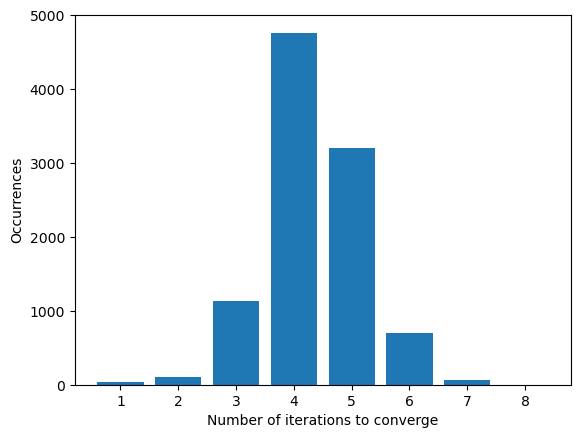

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Dimension of vectors xi, v, and x
C = 256

# For a fixed w, returns the solution x of (14)-(17),
# the optimal multiplier, and the optimal value of the objective function.
def cutting_plane_algorithm_histo(xi, v, w, C):
    # Count the iterations of the algorithm
    iteration = 0
    # Prevent infinite loops
    max_iterations = 100  
    
    # Initialize x1 (x2) as a vector that satisfies w >= v * x1 (w < v * x2) 
    x1, x2 = initialize_B(v, w, C)
    B = [x1, x2]
    while True:
        iteration += 1
        if iteration > max_iterations:
            print("Maximum iterations reached.")
            break

        x1, x2 = B

        # Compute the intersection point (lambda^+, phi^+) also called (lambda_plus, phi_plus)
        numerator = (xi @ x2 - xi @ x1)
        denominator = ((w - v @ x1) - (w - v @ x2))
        if denominator == 0:
            lambda_plus = 0
        else:
            lambda_plus = numerator / denominator
        phi_plus = xi @ x1 + lambda_plus * (w - v @ x1)

        # Compute x^+ (x_plus) as the vector that has a 1 at the position 
        # where xi - lambda_plus * v is minimal
        reduced_cost = xi - lambda_plus * v
        b_plus = np.argmin(reduced_cost)
        x_plus = get_unit_vector(b_plus, C)

        # Compute phi(lambda^+)
        phi_lambda_plus = xi @ x_plus + lambda_plus * (w - v @ x_plus)

        # TERMINATION CONDITIONS
        # Case 1:
        # |phi_lambda_plus - phi_plus| <= 1e-08 + 1e-05 * phi_plus (see default of isclose())
        if np.isclose(phi_lambda_plus, phi_plus):
            # Compute theta^* as the coefficient of the convex combination of x1 and x2 
            # that, when multiplied by v, gives w
            numerator_theta = (w - v @ x2)
            denominator_theta = v @ (x1 - x2)
            if denominator_theta == 0:
                theta_star = 0.5  # Arbitrary value since x1 == x2
            else:
                theta_star = numerator_theta / denominator_theta
            x = theta_star * x1 + (1 - theta_star) * x2
            return iteration, x, lambda_plus, phi_plus
        # Case 2: w = v * x^+
        # x^+ is a primal solution since, in this case, we have minimized xi*x 
        # while satisfying all constraints
        elif np.isclose(w, v @ x_plus):
            x = x_plus
            phi_plus = xi @ x  # The term lambda^+ * (w - v * x^+) becomes 0
            return iteration, x, lambda_plus, phi_plus
        
        else:
            # Case 3: x^+ behaves like x1
            # Iterate the algorithm with x^+ instead of x1
            if w > v @ x_plus:
                B = [x_plus, x2]
            # Case 4: x^+ behaves like x2
            # Iterate the algorithm with x^+ instead of x2
            else:
                B = [x1, x_plus]

iterations = []
for i in range(10000):
    np.random.seed()  # For reproducibility with different seeds
    xi = np.sort(np.random.random(C))
    v = np.linspace(0, 1, C, endpoint=False)
    w = np.random.choice(v)
    
    iteration, x_opt, lambda_opt, phi_opt = cutting_plane_algorithm_histo(xi, v, w, C)
    iterations.append(iteration)

# Count occurrences
occurrences = Counter(iterations)

# Data for the histogram
labels = list(occurrences.keys())  # Labels (unique values)
values = list(occurrences.values())  # Frequencies

# Create the histogram
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Number of iterations to converge')
plt.ylabel('Occurrences')

# Show the histogram
plt.show()


## For a fixed seed, here there is the simulation of 10 thousand 
## istances with cutting plane algorithm and with cvxpy to compare execution times

In [4]:
import time

# Initialize data
C = 256  # Size of vectors xi, v, and x
N = 1000  # Number of iterations for timing comparison

np.random.seed(42)  # Set seed for reproducibility

# Generate random xi vector and v values
xi = np.sort(np.random.random(C))  # Sorted random values for xi
v = np.linspace(0, 1, C, endpoint=False)  # Evenly spaced values between 0 and 1
w = np.random.choice(v)  # Randomly select a value from v as w

# Measure execution time of the Cutting Plane Algorithm
print("Start Cutting Plane Algorithm")
start_time = time.time()
for i in range(N):
    x_opt, lambda_opt, phi_opt = cutting_plane_algorithm(xi, v, w, C)
training_time = time.time() - start_time
print(f'Time taken by the Cutting Plane algorithm: {training_time:.2f} seconds')

print("-" * 40)  # Separator for readability

# Measure execution time of the cvxpy solver
print("Start cvxpy solver")
start_time = time.time()
for i in range(N):
    # Define optimization variable
    x = cp.Variable(C)
    
    # Define constraints
    equality_constraint = v @ x == w  # Enforce v * x = w
    constraints = [
        equality_constraint,
        cp.sum(x) == 1,  # Ensure x sums to 1
        x >= 0,  # Ensure non-negativity
        x <= 1   # Ensure x values do not exceed 1
    ]
    
    # Define objective function (minimize xi * x)
    objective = cp.Minimize(xi @ x)
    
    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
training_time = time.time() - start_time
print(f'Time taken by the cvxpy solver: {training_time:.2f} seconds')


Start Cutting Plane Algorithm
Time taken by the Cutting Plane algorithm: 0.21 seconds
----------------------------------------
Start cvxpy solver
Time taken by the cvxpy solver: 3.00 seconds


## Comparison between cvxpy and vectorized cutting plane

In [5]:
import torch

# Configure PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
C = 5  # Size of vectors xi, v, and x
N = 10000  # Number of problems in the batch

# Generate random data
np.random.seed(10)
xi_np = np.sort(np.random.random(C))  # Sorted random values for xi
v_np = np.array([0.0, 0.2, 0.4, 0.6, 0.8])  # Fixed vector v
w_np = np.random.choice(v_np, N)  # Randomly select N values from v as w

# Convert numpy arrays to PyTorch tensors
xi = torch.tensor(xi_np, dtype=torch.float32, device=device)
v = torch.tensor(v_np, dtype=torch.float32, device=device)
w = torch.tensor(w_np, dtype=torch.float32, device=device)

# Function to generate unit vectors
def get_unit_vectors(indices, size):
    """ Creates unit vectors based on given indices. """
    x = torch.zeros(indices.size(0), size, device=device)
    x[torch.arange(indices.size(0)), indices] = 1.0
    return x

# Function to initialize B with two vectors satisfying w >= v * x1 and w < v * x2
def initialize_B(v, w, C):
    """ Initializes x1 and x2 for the cutting plane algorithm. """
    v_expanded = v.unsqueeze(0).repeat(w.size(0), 1)  # Expand v to match w's batch size
    w_expanded = w.unsqueeze(1)  # Expand w for broadcasting
    diff = v_expanded - w_expanded  # Compute the difference

    # Find indices where w is between v values
    b1 = torch.sum(diff <= 0, dim=1) - 1
    b2 = b1 + 1

    # Clamp values to stay within valid index range
    b1 = torch.clamp(b1, 0, C - 1)
    b2 = torch.clamp(b2, 0, C - 1)

    # Create unit vectors
    x1 = get_unit_vectors(b1, C)
    x2 = get_unit_vectors(b2, C)

    return x1, x2

# Vectorized cutting plane algorithm implementation
def cutting_plane_algorithm_vectorized(xi, v, w, x1, x2):
    """ Cutting plane algorithm optimized for batch processing with PyTorch. """
    max_iterations = 8  # Limit the number of iterations
    iteration = 0
    x_plus = x1.clone()  # Initialize x_plus
    lambda_plus = torch.zeros(N, device=device)  # Initialize lambda_plus
    phi_plus = torch.zeros(N, device=device)  # Initialize phi_plus

    while iteration < max_iterations:
        iteration += 1

        # Compute necessary inner products
        xi_x1 = torch.sum(xi * x1, dim=1)
        xi_x2 = torch.sum(xi * x2, dim=1)
        v_x1 = torch.sum(v * x1, dim=1)
        v_x2 = torch.sum(v * x2, dim=1)

        # Compute lambda^+ and phi^+
        numerator = xi_x2 - xi_x1
        denominator = (w - v_x1) - (w - v_x2) + 1e-8  # Avoid division by zero
        lambda_plus = numerator / denominator
        phi_plus = xi_x1 + lambda_plus * (w - v_x1)

        # Compute x^+ as the unit vector minimizing xi - lambda^+ * v
        reduced_cost = xi.unsqueeze(0) - lambda_plus.unsqueeze(1) * v.unsqueeze(0)
        b_plus = torch.argmin(reduced_cost, dim=1)
        x_plus = get_unit_vectors(b_plus, C)

        # Compute phi(lambda^+)
        phi_lambda_plus = torch.sum(xi * x_plus, dim=1) + lambda_plus * (w - torch.sum(v * x_plus, dim=1))

        # Check termination conditions
        termination_condition = torch.isclose(phi_lambda_plus, phi_plus, atol=1e-6)
        w_equals_vx_plus = torch.isclose(w, torch.sum(v * x_plus, dim=1), atol=1e-6)

        # If all samples satisfy termination conditions, return solution
        if torch.all(termination_condition | w_equals_vx_plus):
            numerator_theta = w - torch.sum(v * x2, dim=1)
            denominator_theta = torch.sum(v * (x1 - x2), dim=1) + 1e-8  # Avoid division by zero
            theta_star = numerator_theta / denominator_theta
            theta_star = torch.clamp(theta_star, 0, 1)  # Ensure valid range

            # Compute final solution as a convex combination of x1 and x2
            x = theta_star.unsqueeze(1) * x1 + (1 - theta_star).unsqueeze(1) * x2
            return x, lambda_plus, phi_plus

        # Update B for the next iteration
        condition = w > torch.sum(v * x_plus, dim=1)
        x1 = torch.where(condition.unsqueeze(1), x_plus, x1)
        x2 = torch.where(~condition.unsqueeze(1), x_plus, x2)

    return x_plus, lambda_plus, phi_plus  # Return last computed values

# Measure execution time for the vectorized Cutting Plane Algorithm
x1, x2 = initialize_B(v, w, C)
start_time = time.time()
x_opt, lambda_opt, phi_opt = cutting_plane_algorithm_vectorized(xi, v, w, x1, x2)
cutting_plane_time = time.time() - start_time
print(f"\nTime taken by Vectorized Cutting Plane Algorithm: {cutting_plane_time:.3f} seconds")

# Measure execution time for cvxpy solver
start_time = time.time()
for i in range(N):
    x = cp.Variable(C)

    # Define constraints
    constraints = [
        v_np @ x == w_np[i],  # Equality constraint
        cp.sum(x) == 1,  # Ensure sum of x is 1
        x >= 0,  # Ensure non-negativity
        x <= 1   # Ensure x values do not exceed 1
    ]

    # Define objective function (minimize xi * x)
    objective = cp.Minimize(xi_np @ x)

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

cvxpy_time = time.time() - start_time
print(f"Time taken by cvxpy solver: {cvxpy_time:.3f} seconds")



Time taken by Vectorized Cutting Plane Algorithm: 0.002 seconds
Time taken by cvxpy solver: 14.850 seconds


## KNAPSACK SPECIALIZED

In [6]:
def knapsack_specialized(xi, v, w, C):
    """
    Solves a specialized knapsack problem using a specialized method in a vectorized way

    Args:
        xi (torch.Tensor): xi variables.
        v (torch.Tensor): Quantization vector.
        w (torch.Tensor): Weight vector.
        C (int): Number of buckets of quantization.

    Returns:
        tuple: Optimal allocation (x_opt), optimal multipliers (lambda_opt), and objective values.
    """
    
    b_list = []
    b = 0

    # Compute breakpoint vector x_plus
    while True:
        delta_xi = (xi[b + 1:] - xi[b])
        delta_v = (v[b + 1:] - v[b])
        b = torch.argmin(delta_xi / delta_v) + 1 + b_list[-1] if b_list else 0

        if b != C - 1:
            b_list.append(int(b))

        if b + 1 > C - 1:
            break
    b_list.append(C - 1)
    x_plus = torch.zeros(C, dtype=torch.int32)
    b_tensor = torch.tensor(b_list, dtype=torch.int32)
    x_plus[b_tensor] = 1

    # Determine optimal allocation based on w
    w_idx = torch.searchsorted(v, w) 
    indices_breakpoints = torch.nonzero(x_plus == 1).squeeze()

    # Creation of masks for extreme cases
    mask_right = w > v[-1]
    mask_left = w < v[0]

    # Find indices using searchsorted
    search_idx = torch.searchsorted(indices_breakpoints, w_idx)

    # Ensure that the indices are valid
    search_idx = torch.clamp(search_idx, 1, len(indices_breakpoints) - 1)

    # Initialize idx_right and idx_left with the result of the search
    idx_right = indices_breakpoints[search_idx]
    idx_left = indices_breakpoints[search_idx - 1]

    # Correct the indices for extreme cases
    idx_right = torch.where(mask_right, indices_breakpoints[-1], idx_right)
    idx_left = torch.where(mask_right, indices_breakpoints[-1], idx_left)

    # Correct the indices for the case when w < v[0]
    idx_right = torch.where(mask_left, indices_breakpoints[0], idx_right)
    idx_left = torch.where(mask_left, indices_breakpoints[0], idx_left)

    # Compute convex combination for optimal solution
    x1, x2 = torch.zeros(2, len(w), C, dtype=torch.float32)

    x1[torch.arange(len(w)), idx_left] = 1
    x2[torch.arange(len(w)), idx_right] = 1

    numerator = w - torch.matmul(x2, v)
    denominator = torch.matmul((x1 - x2), v)
    theta = numerator / denominator

    mask_equal = (x1 == x2)
    theta_expanded = theta.unsqueeze(1)
    x_opt = torch.where(mask_equal, x1, x1 * theta_expanded + x2 * (1 - theta_expanded))

    # Compute optimal multipliers
    denominator = (v[idx_right] - v[idx_left])
    denominator_zero_mask = denominator == 0

    lambda_opt_nonzero = (xi[idx_right] - xi[idx_left]) / denominator
    lambda_opt_zero_full = xi / v
    lambda_opt_zero_full[0] = 0
    lambda_opt_zero = lambda_opt_zero_full[idx_left]

    lambda_opt = torch.where(denominator_zero_mask, lambda_opt_zero, lambda_opt_nonzero)

    # Compute objective function values
    objective_values = torch.matmul(x_opt, xi)

    return x_opt, lambda_opt, objective_values

## Verify correctness

In [7]:
np.random.seed(42)  
C = 256
M = 100
CORRECT = True

for i in range(1000):
    xi = torch.sort(torch.rand(C, device=device))[0]  
    v = torch.linspace(0, 1 - (1 / C), C, device=device)  
    #w = v[torch.randint(0, C, (1,), device=device)]  
    w = torch.rand(M, device=device)
    
    x1, x2 = initialize_B(v, w, C)
    x_opt1, lambda_opt1, phi_opt1 = cutting_plane_algorithm_vectorized(xi, v, w, x1, x2)
    
    x_opt2, lambda_opt2, phi_opt2 = knapsack_specialized(xi, v, w, C)
    
    # Comparison of solutions
    if(torch.any(torch.abs(x_opt1 - x_opt2) > 1e-3) and torch.any(phi_opt1 + 1e-4 < phi_opt2)):
        #print("x_opt1:", x_opt1)
        print("phi_opt1:", phi_opt1)
        #print("x_opt2:", x_opt2)
        print("phi_opt2:", phi_opt2)
        print("ERROR! Algorithms provide different solutions!")
        CORRECT = False

if(CORRECT == True):
    print("The algorithm is correct!")

The algorithm is correct!


## Compare execution times

In [8]:
# Initialize data
C = 256  
N = 1000  # Number of iterations for timing comparison
M = 44000 # Parallelization
np.random.seed(42)  # Set seed for reproducibility

v = torch.linspace(0, 1 - (1 / C), C, device=device)  

# Measure execution time of the Cutting Plane Algorithm
print("Start Cutting Plane Algorithm")
start_time = time.time()
for i in range(N):
    xi = torch.sort(torch.rand(C, device=device))[0]  
    w = torch.rand(M, device=device)
    x1, x2 = initialize_B(v, w, C)
    x_opt1, lambda_opt1, phi_opt1 = cutting_plane_algorithm_vectorized(xi, v, w, x1, x2)
training_time1 = time.time() - start_time
print(f'Time taken by the Cutting Plane algorithm: {training_time1:.2f} seconds')

print("-" * 40)  # Separator for readability

# Measure execution time of the specialized algorithm
print("Start Specialized Algorithm")
start_time = time.time()
for i in range(N):
    x_opt2, lambda_opt2, phi_opt2 = knapsack_specialized(xi, v, w, C)
training_time2 = time.time() - start_time
print(f'Time taken by the specialized algorithm: {training_time2:.2f} seconds')


Start Cutting Plane Algorithm
Time taken by the Cutting Plane algorithm: 214.12 seconds
----------------------------------------
Start Specialized Algorithm
Time taken by the specialized algorithm: 18.87 seconds


In [9]:
print(f"The specialized algorithm results in {training_time1 / training_time2:.2f}x better performance")

The specialized algorithm results in 11.35x better performance
